# Introduction to SISO

In [1]:
import numpy as np
from mdof.utilities.printing import *
from mdof.utilities.testing import test_method
from mdof.utilities.config import Config
import mdof
from mdof import modal, transform
from control import ss, forced_response

## Define a SDOF system
parameter | value
----------|-------
m  | mass
k  | stiffness
c  | damping coefficient
nt | number of timesteps
dt | timestep

![sdof](./figures/sdof.png)

In [2]:
# parameters of SDOF system
mass = 1       # mass
k = 30         # stiffness
zeta = 0.01    # damping ratio
omega_n = np.sqrt(k/mass)  # natural frequency (rad/s)
Tn = 2*np.pi/omega_n  # natural periods (s)
c = 2*zeta*mass*omega_n    # damping coefficient
print(f"natural period: {Tn:<3.5}s")
print(f"damping ratio: {zeta}")

# forcing frequencies (rad/s)
omega_f = [0.017*omega_n, 0.14*omega_n, 0.467*omega_n, 0.186*omega_n, 0.2937*omega_n]

natural period: 1.1471s
damping ratio: 0.01


In [3]:
# forcing function (input)
nt = 5000       # number of timesteps
dt = 0.03       # timestep
tf = nt*dt      # final time
t = np.arange(start = 0, stop = tf, step = dt)
f = np.sum(np.sin([omega*t for omega in omega_f]), axis=0)

In [4]:
# displacement response (analytical solution) (output)
omega_D = omega_n*np.sqrt(1-zeta**2)
y = np.zeros((len(omega_f),nt))
for i,omega in enumerate(omega_f):
    C3 = (1/k)*(1-(omega/omega_n)**2)/((1-(omega/omega_n)**2)**2+(2*zeta*omega/omega_n))**2
    C4 = -(2*zeta*omega/omega_n)*(1-(omega/omega_n)**2)/((1-(omega/omega_n)**2)**2+(2*zeta*omega/omega_n))**2
    C1 = -C4
    C2 = (zeta*omega_n*C1-omega*C3)/omega_D
    y[i,:] = np.exp(-zeta*omega_n*t)*(C1*np.cos(omega_D*t)+C2*np.sin(omega_D*t)) + C3*np.sin(omega*t) + C4*np.cos(omega*t)
y = np.sum(y,axis=0)

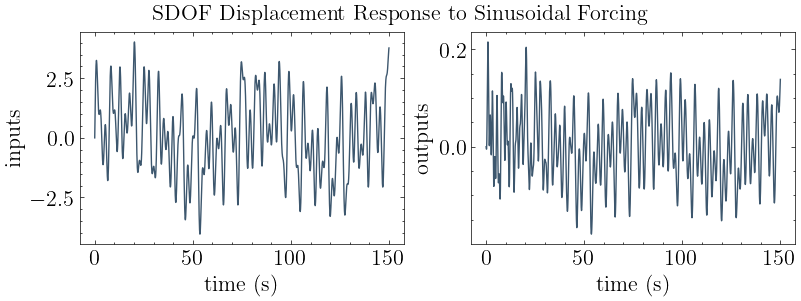

In [5]:
# plot input vs. output
plot_io(inputs=f, outputs=y, t=t, title="SDOF Displacement Response to Sinusoidal Forcing")

## Perform System Identification

### Transfer Function Methods

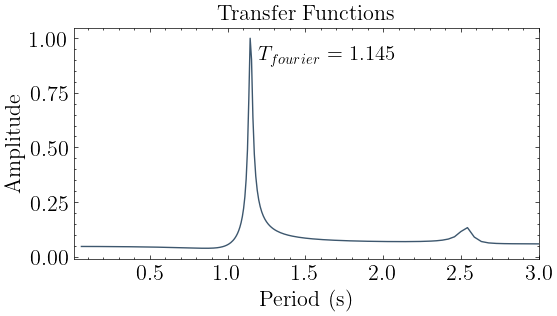

In [6]:
# Set parameters
conf = Config()
conf.damping = zeta
conf.period_band = (0.01,3) # Period band (s)

# A place to store models and their predictions
transfer_models = {}

# Generate a transfer function representation of the system
transfer_models["Fourier Transform"] = transform.fourier_transfer(inputs=f, outputs=y, step=dt, **conf)
# transfer_models["Response Spectrum"] = transform.response_transfer(inputs=f, outputs=y, step=dt, pseudo=False, threads=8, periods=(*conf.period_band, 500), **conf)

# Determing the fundamental frequency
fourier_periods, fourier_amplitudes = modal.spectrum_modes(*transfer_models["Fourier Transform"])
# response_periods, response_amplitudes = modal.spectrum_modes(*transfer_models["Response Spectrum"],height=0.1)
plot_transfer(transfer_models, title="Transfer Functions")
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
# plt.vlines([fourier_periods[0], response_periods[0]],ymin=0,ymax=1,linestyles='--',colors=color_cycle[:2])
plt.text(fourier_periods[0]+0.05,0.9,r"$T_{fourier}$ = "+str(np.round(fourier_periods[0],3)),fontsize=15)
# plt.text(response_periods[0]+0.05,0.8,r"$T_{response}$ = "+str(np.round(response_periods[0],3)),fontsize=15)
plt.xlim(conf.period_band);
# plt.gcf().set_figwidth(9)
# plt.legend();

### State Space Methods

In [7]:
# Generate a state space realization of the system
A,B,C,D = mdof.system(inputs=f, outputs=y, r=2)
# Obtain natural period and damping ratio from the state space model
ss_modes = modal.system_modes((A,B,C,D),dt,outlook=190)
print_modes(ss_modes, Tn=Tn, zeta=zeta)

100%|█████████▉| 4700/4701 [00:00<00:00, 86808.38it/s]

Spectral quantities:
       T(s)        ζ        EMACO      MPC       EMACO*MPC     T % error    ζ % error
      1.147      0.01       1.0        1.0        1.0          9.678e-14    1.622e-11
Mean Period(s): 1.1471474419090963
Standard Dev(s): 0.0


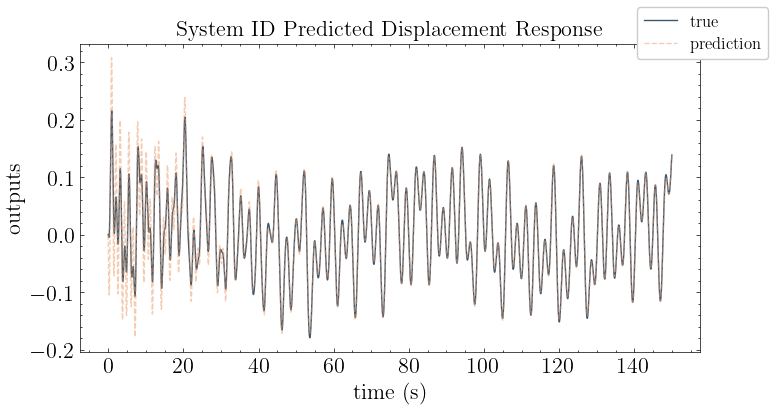

In [8]:
# Reproduce the response with the state space model
y_mdof = forced_response(ss(A,B,C,D,dt), T=t, U=f, squeeze=False, return_x=False).outputs
plot_pred(ytrue=y, models=y_mdof, t=t, title="System ID Predicted Displacement Response")

## Breakdown of State Space Methods

### General Parameters
parameter | value
----------|-------
`p ` | number of output channels
`q ` | number of input channels
`nt` | number of timesteps
`dt` | timestep
`decimation`  | decimation (downsampling) factor
`order` | model order (2 times number of DOF)

### Parameters for Mode Validation
parameter | value
----------|-------
`outlook` | number of steps used for temporal consistency in EMAC

### Method Inputs

In [9]:
# Set parameters
conf = Config()
conf.m  = 1500
conf.horizon = 150
conf.nc = 150
conf.order  =   2
conf.a  =   0
conf.b  =   0
conf.l  =  10
conf.g  =   3

# A place to store models and their predictions
models = {}

### Specific to Observer Kalman Identification (OKID)
parameter | value
----------|-------
`m`  | number of Markov parameters to compute (at most = nt)

### Specific to Eigensystem Realization Algorithm (ERA)
parameter | value
----------|-------
`horizon` | number of observability parameters, or prediction horizon
`nc` | number of controllability parameters

### OKID-ERA

In [10]:
# OKID-ERA
method = "okid-era"
models[method] = test_method(method=method, inputs=f, outputs=y, dt=dt, t=t, **conf)
print_modes(models[method]["modes"], Tn=Tn, zeta=zeta)

Spectral quantities:
       T(s)        ζ        EMACO      MPC       EMACO*MPC     T % error    ζ % error
      1.801      0.3442     1.0        1.0        1.0          57.01        3.342e+03
Mean Period(s): 1.8011804589415248
Standard Dev(s): 0.0


### Specific to Data Correlations (DC)
parameter | value
----------|-------
`a`  | (alpha) number of additional block rows in Hankel matrix of correlation matrices
`b`  | (beta) number of additional block columns in Hankel matrix of correlation matrices
`l`  | initial lag
`g`  | lag (gap) between correlations

### OKID-ERA-DC

In [11]:
# OKID-ERA-DC
method = "okid-era-dc"
models[method] = test_method(method=method, inputs=f, outputs=y, dt=dt, t=t, **conf)
print_modes(models[method]["modes"], Tn=Tn, zeta=zeta)

Spectral quantities:
       T(s)        ζ        EMACO      MPC       EMACO*MPC     T % error    ζ % error
      1.776      0.2423     1.0        1.0        1.0          54.85        2.323e+03
Mean Period(s): 1.7763378693304586
Standard Dev(s): 0.0


### Specific to System Realization with Information Matrix (SRIM)
parameter | value
----------|-------
`horizon` | number of steps used for identification, or prediction horizon

### SRIM

In [12]:
# SRIM
method = "srim"
models[method] = test_method(method=method, inputs=f, outputs=y, dt=dt, t=t, **conf)
print_modes(models[method]["modes"], Tn=Tn, zeta=zeta)

100%|█████████▉| 4850/4851 [00:00<00:00, 80591.63it/s]

Spectral quantities:
       T(s)        ζ        EMACO      MPC       EMACO*MPC     T % error    ζ % error
      1.147      0.01       1.0        1.0        1.0          1.295e-11    8.338e-10
Mean Period(s): 1.1471474419092438
Standard Dev(s): 0.0


### Compare Methods

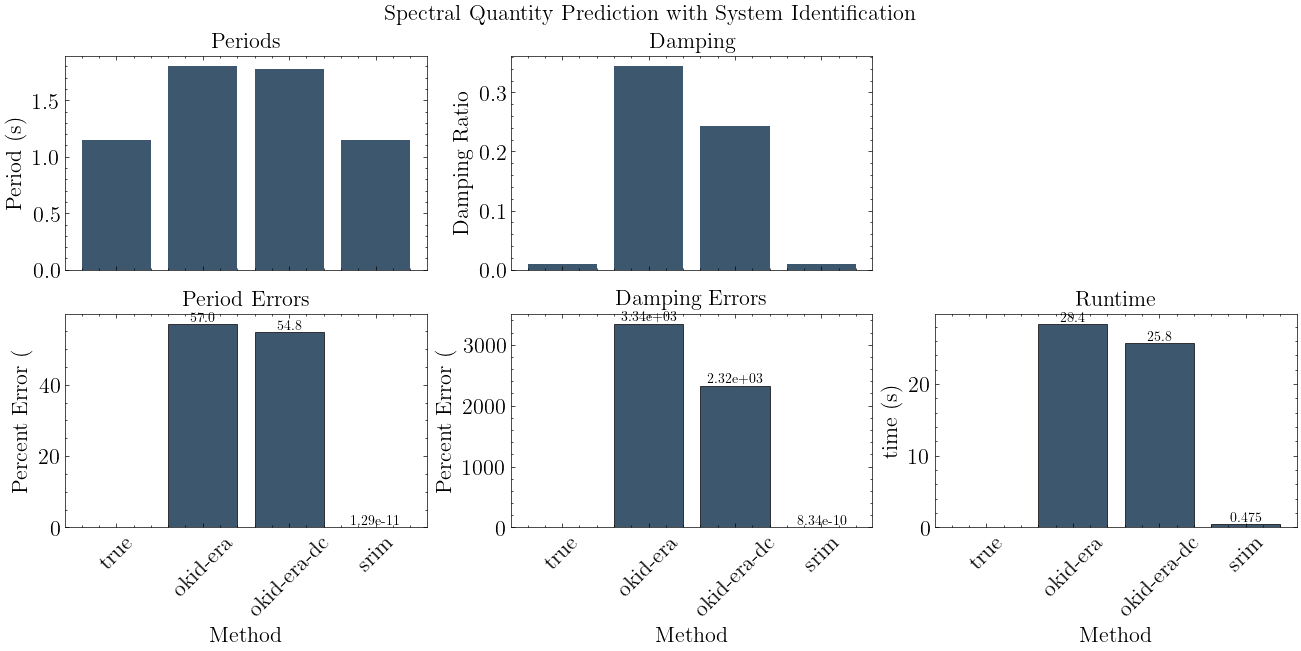

In [13]:
plot_models(models, Tn, zeta)

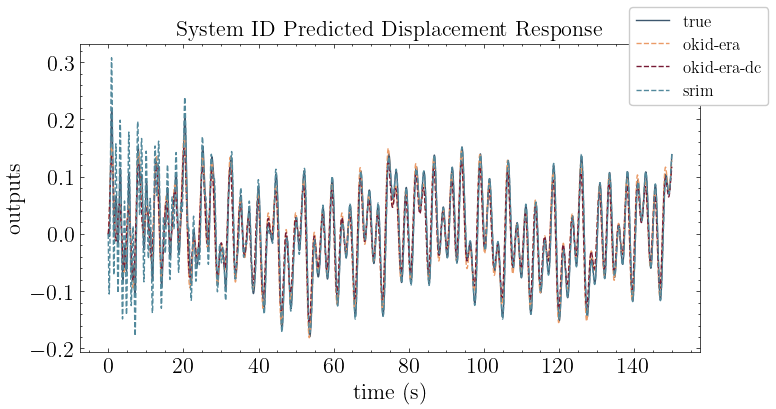

In [14]:
plot_pred(ytrue=y, models=models, t=t, title="System ID Predicted Displacement Response")